<a href="https://www.kaggle.com/code/duygukranolu/sentiment-analysis-and-modeling?scriptVersionId=247343879" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="background: linear-gradient(to right, #FF8C00, #FFDAB9, #FF8C00); padding: 20px; border-radius: 12px; font-weight: bold; text-align: center; font-size: 30px; color: #4A4A4A; border: 2px solid #FF8C00;">
Amazon Ürün Yorumları Üzerinden Duygu Analizi ve Modelleme Çalışması
</div>

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Bu çalışmada, Amazon platformunda yer alan bir ürüne (ASIN: B007WTAJTO) ait kullanıcı yorumları temel alınarak duygu analizi gerçekleştirilecektir. Analiz süreci iki aşamalı bir yaklaşımla yürütülecektir.
<br><br> İlk aşamada, ürünle ilgili metin tabanlı değerlendirmeler üzerinden unsupervised (denetimsiz) öğrenme yöntemleri kullanılarak her bir yoruma ait duygu puanı (compound score) hesaplanacaktır. Bu skorlar doğrultusunda yorumlar pozitif veya negatif olarak etiketlenecek ve böylece yorumlara yönelik "pseudo-label" (sözde etiket) oluşturulacaktır.<br><br>

İkinci aşamada ise, elde edilen bu etiketler kullanılarak supervised (denetimli) makine öğrenmesi modelleri ile sınıflandırma işlemi gerçekleştirilecektir. Bu kapsamda, kullanıcı yorumları doğal dil işleme (NLP) teknikleri ile temizlenecek, sayısal vektörlere dönüştürülecek ve Random Forest algoritma ile model eğitilecektir.<br><br>

Çalışmanın nihai amacı, kullanıcı yorumlarının içerdiği duygu durumlarını otomatik olarak tespit edebilen etkili bir metin sınıflandırma modeli geliştirmektir. 
</div>

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">
    <p><strong>Veri Seti Özellikleri:</strong></p>
    <ul>
        <li>reviewerID:Kullanıcı ID</li>
        <li>asin: Ürün ID</li>
        <li>reviewerName: Kullanıcı Adı</li>
        <li>helpful: Faydalı değerlendirme derecesi</li>
        <li><strong>reviewText: Değerlendirme </strong> </li>
        <li>overall: Ürün rating’i</li>
        <li>summary: Değerlendirme özeti</li>
        <li>unixReviewTime: Değerlendirme zamanı</li>
        <li>reviewTime: Değerlendirme zamanı Raw</li>
        <li>day_diff: Değerlendirmeden itibaren geçen gün sayısı</li>
        <li>helpful_yes: Değerlendirmenin faydalı bulunma sayısı</li>
        <li>total_vote: Değerlendirmeye verilen oy sayısı</li>
    </ul>
</div>

## <span style="color:#FA8072">  Kütüphanelerin Import Edilmesi </span> <a class="anchor" id="import_libraries"></a>

In [1]:
# Pip yüklemeleri (sessiz mod)
!pip install -q nltk
!pip install -q textblob
!pip install -q wordcloud

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.preprocessing import LabelEncoder
from warnings import filterwarnings
filterwarnings('ignore')

# Pandas ayarları
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
# ==============================
# NLTK VERİLERİNİ İNDİR
# ==============================

import nltk
nltk.download('punkt')           # Tokenization için
nltk.download('stopwords')       # İngilizce stopword'ler için
nltk.download('wordnet')         # Lemmatization için WordNet sözlüğü
nltk.download('omw-1.4')         # WordNet destek paketi
nltk.download('vader_lexicon')   # VADER duygu analizi için sözlük

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [4]:
# ==============================
# STOPWORDS ve LEMMATIZER
# ==============================

sw = set(stopwords.words('english'))  # İngilizce stopword listesi
lemmatizer = WordNetLemmatizer()      # Lemmatizer nesnesi

## <span style="color:#FA8072">  Veri Setini Okuma </span> <a class="anchor" id="load_data"></a>

In [5]:
df = pd.read_csv("/kaggle/input/amazon-rating-review/amazon_review.csv")

## <span style="color:#FA8072">  Veriye İlk Bakış </span> <a class="anchor" id="load_data"></a>

In [6]:
# Veri setinin ilk 5 gözlemini görelim.
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4.00,Four Stars,1406073600,2014-07-23,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5.00,MOAR SPACE!!!,1382659200,2013-10-25,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4.00,nothing to really say....,1356220800,2012-12-23,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5.00,Great buy at this price!!! *** UPDATE,1384992000,2013-11-21,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5.00,best deal around,1373673600,2013-07-13,513,0,0


In [7]:
# Burada sadece kullanıcı yorumları ("reviewText") temel alınarak çalışmalar gerçekleşecektir.
rows, cols = df.shape
print(f"Satır(Gözlem) Sayısı: {rows} \nSütun(Değişken) Sayısı: {cols}")

Satır(Gözlem) Sayısı: 4915 
Sütun(Değişken) Sayısı: 12


## <span style="color:#FA8072"> 1. Metin Ön İşleme (Text Preprocessing) </span> <a class="anchor" id="load_data"></a> 

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Amazon yorumları, kullanıcılar tarafından serbest biçimde yazıldığı için dil bilgisi, yazım şekli ve içerik bakımından oldukça heterojendir. Bu nedenle veriyi modele uygun hâle getirmek için çeşitli ön işleme adımlarına ihtiyaç duyulur.
</div>

## <span style="color:#FA8072"> 🔸 1.1 Harf Standartlaştırma (Normalizing Case Folding) </span> <a class="anchor" id="load_data"></a> 

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Bazı kelimeler büyük, bazıları küçük harfle yazılmış olabilir. Tüm metin küçük harfe çevrilerek standartlaştırılır.
</div>

In [8]:
df["reviewText"] = df["reviewText"].str.lower()

In [9]:
df["reviewText"]

0                                              no issues.
1       purchased this for my device, it worked as adv...
2       it works as expected. i should have sprung for...
3       this think has worked out great.had a diff. br...
4       bought it with retail packaging, arrived legit...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable. it ...
4913    good amount of space for the stuff i want to d...
4914    i've heard bad things about this 64gb micro sd...
Name: reviewText, Length: 4915, dtype: object

## <span style="color:#FA8072"> 🔸 1.2 Noktalama İşaretlerinin Kaldırılması (Punctuation Removal) </span> <a class="anchor" id="load_data"></a> 

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Noktalama işaretleri genellikle duygusal anlam taşımazlar ve model performansına katkı sağlamazlar.
</div>

In [10]:
df['reviewText'] = df['reviewText'].str.replace('[^\w\s]', '',regex=True)

In [11]:
df['reviewText']

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk 16gb class 10 to use wit...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this 64gb micro sd ...
Name: reviewText, Length: 4915, dtype: object

## <span style="color:#FA8072"> 🔸 1.3 Sayıların Kaldırılması </span> <a class="anchor" id="load_data"></a> 

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Metinde geçen sayılar, duygu taşımaz ve genellikle analizde kullanılmaz. Ancak bazı istisnalarda (örn. "10/10", "1 star") sayı duyguyu doğrudan ifade edebilir. Bu nedenle, sayının geçtiği cümlede ne anlatılmak istendiğine göre karar verilmelidir.
</div>

In [12]:
df['reviewText'] = df['reviewText'].str.replace('\d', '', regex=True)

In [13]:
df['reviewText']

0                                               no issues
1       purchased this for my device it worked as adve...
2       it works as expected i should have sprung for ...
3       this think has worked out greathad a diff bran...
4       bought it with retail packaging arrived legit ...
                              ...                        
4910    i bought this sandisk gb class  to use with my...
4911    used this for extending the capabilities of my...
4912    great card that is very fast and reliable it c...
4913    good amount of space for the stuff i want to d...
4914    ive heard bad things about this gb micro sd ca...
Name: reviewText, Length: 4915, dtype: object

## <span style="color:#FA8072"> 🔸 1.4 Stopwords Temizliği </span> <a class="anchor" id="load_data"></a> 

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
"the", "is", "of", "this", "like", "stuff", "actually", "after" gibi bağlaçlar, zamirler ve genel kullanımda olan ancak metne ölçümsel katkı sağlamayan kelimeler stopword kabul edilerek silinir.
</div>

In [14]:
sw = stopwords.words('english')

print(sw[:10])  # İlk 10 stopword'ü yazdır

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


In [15]:
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(
                                           word for word in word_tokenize(str(x)) if word not in sw and word.isalpha()
))

In [16]:
df['reviewText']

0                                                  issues
1       purchased device worked advertised never much ...
2       works expected sprung higher capacity think ma...
3       think worked greathad diff bran gb card went s...
4       bought retail packaging arrived legit orange e...
                              ...                        
4910    bought sandisk gb class use htc inspire months...
4911    used extending capabilities samsung galaxy not...
4912    great card fast reliable comes optional adapte...
4913          good amount space stuff want fits gopro say
4914    ive heard bad things gb micro sd card crapping...
Name: reviewText, Length: 4915, dtype: object

## <span style="color:#FA8072"> 🔸 1.5 Nadir Kelimelerin Kaldırılması </span> <a class="anchor" id="load_data"></a> 

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Çalışma kapsamında yalnızca belirli bir sıklığın üzerinde geçen kelimeler tutulur. Nadir geçen kelimeler (frekansı 1 olanları, örüntü oluşturma ihtimali düşük olduğu için) çıkarılır.
</div>

In [17]:
# Bütün kelimelerin kaç kez geçtiğini bulalım
temp_df = pd.Series(' '.join(df['reviewText']).split()).value_counts()

# Sadece 1 kez geçen nadir kelimeleri alalım
drops = temp_df[temp_df <= 1].index

# Nadir kelimeleri (1 kez geçen) kaldır
df['reviewText'] = df['reviewText'].apply(
    lambda x: " ".join([word for word in word_tokenize(str(x)) if word not in drops])
)

## <span style="color:#FA8072"> 🔸 1.6 Lemmatization </span> <a class="anchor" id="load_data"></a> 

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Benzer anlam taşıyan kelimeleri dil bilgisi kurallarına uygun şekilde ortak bir köke indirgemek için bu çalışmada lemmatization yöntemi kullanılmıştır. Örneğin: "running", "ran", "runs" hepsi "run" köküne indirgenir. 
</div>

In [18]:
# Lemmatization işlemi
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(
    [lemmatizer.lemmatize(word) for word in word_tokenize(x)]
))

## <span style="color:#FA8072"> 2. Metin Görselleştirme (WordCloud) </span> <a class="anchor" id="load_data"></a> 

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Metin verisindeki en sık geçen kelimeleri görsel olarak öne çıkarmak ve genel yorum temasını daha iyi anlamak amacıyla WordCloud (kelime bulutu) yöntemi kullanılmıştır.
</div>

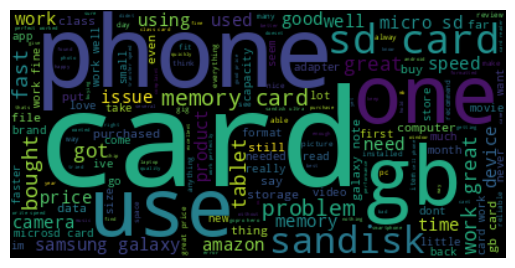

In [19]:
text = " ".join(i for i in df.reviewText)

wordcloud = WordCloud().generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

wordcloud.to_file("wordcloud.png")

## <span style="color:#FA8072"> 3. Duygu Analizi </span> <a class="anchor" id="load_data"></a>

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Duygu analizi, elimizdeki metinlerin taşıdığı olumlu, olumsuz veya nötr duygu durumunu matematiksel olarak ifade etmeyi amaçlayan doğal dil işleme (NLP) yöntemlerinden biridir. Bu süreçte, her bir kelimenin sözlük temelli olarak pozitif, negatif ya da nötr bir anlam taşıdığı varsayılır ve bu anlamlar bütüncül bir şekilde değerlendirilerek metnin genel duygu yönelimi belirlenir.
<br><br>Bu yöntem, önceden etiketlenmiş veriye ihtiyaç duymadığı için unsupervised (denetimsiz) öğrenme yaklaşımı kapsamında değerlendirilir. <br><br>
    Bu çalışma kapsamında, metinlerin duygu durumlarını analiz etmek amacıyla VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon tabanlı analiz yöntemi kullanılmıştır.
 <div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">
    <p><strong>VADER ile yapılan analizde, her bir yorum tek tek ele alınarak compound skoru hesaplanır. Bu skor:</strong></p>
    <ul>
        <li>1’e yaklaştıkça pozitif</li>
        <li>-1’e yaklaştıkça negatif,</li>
        <li>0’a yaklaştıkça nötr bir duygu yönelimini ifade eder.</li>
    </ul>
</div>   
</div>

In [20]:
sia = SentimentIntensityAnalyzer()

df["polarity_score"] = df["reviewText"].apply(lambda x: sia.polarity_scores(x)["compound"])

In [21]:
df["polarity_score"]

0      0.00
1      0.00
2      0.40
3      0.65
4      0.86
       ... 
4910   0.08
4911   0.18
4912   0.85
4913   0.69
4914   0.53
Name: polarity_score, Length: 4915, dtype: float64

## <span style="color:#FA8072"> 3.1  Compound Skorlarına Göre Duygu Etiketi Ekleme </span> <a class="anchor" id="load_data"></a>

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Bu işlem sonucunda yorumlar yalnızca "Positive" ve "Negative" olarak etiketlenmiş, "Neutral" (nötr) sınıf ise analiz dışında bırakılarak "Negative" etiketiyle birleştirilmiştir. Böylece veri, ikili (binary) sınıflandırmaya uygun hale getirilmiş ve duygu analizi problemi bir denetimli öğrenme (supervised learning) problemine dönüştürülmüştür.

Bu süreçte, VADER ile hesaplanan "polarity_score" değerleri temel alınarak "sentiment_label" isimli yeni bir bağımlı değişken (target variable) oluşturulmuştur. 
</div>

In [22]:
# Compound skorunu duygu etiketine çeviren fonksiyon
def get_sentiment(score):
    if score >= 0.05:
        return "Positive"
    else:
        return "Negative"

# Her yoruma duygu etiketi ekle
df["sentiment"] = df["polarity_score"].apply(get_sentiment)

In [23]:
df["sentiment"]

0       Negative
1       Negative
2       Positive
3       Positive
4       Positive
          ...   
4910    Positive
4911    Positive
4912    Positive
4913    Positive
4914    Positive
Name: sentiment, Length: 4915, dtype: object

## <span style="color:#FA8072"> 4. Duygu Modelleme </span> <a class="anchor" id="load_data"></a>

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
Bu bölümdeki amaç, metinleri sınıflandırabilecek bir makine öğrenmesi modeli kurmaktır. Oluşturulan model sayesinde, sisteme verilen herhangi bir yorumun olumlu (positive) mu yoksa olumsuz (negative) mu olduğunu otomatik olarak tahmin etmek hedeflenmektedir. Bu işlem için hedef değişken olarak "sentiment_label" sütunu kullanılmıştır.
</div>

## <span style="color:#FA8072"> 🔸 4.1 Etiket Sayısallaştırma (Label Encoding) </span> <a class="anchor" id="load_data"></a>

In [24]:
# Bu adım sonucunda modelin hedef değişkeni sayısal bir form kazanmış olur.
le = LabelEncoder()
df['sentiment_label'] = le.fit_transform(df['sentiment'])

## <span style="color:#FA8072"> 🔸 4.2 Bağımlı ve Bağımsız Değişkenlerin Belirlenmesi </span> <a class="anchor" id="load_data"></a>

In [25]:
X = df["reviewText"]              # Girdi değişkeni (bağımsız)
y = df["sentiment_label"]         # Hedef değişken (bağımlı)

## <span style="color:#FA8072"> 🔸4.3 Veri Setinin Denge Durumu </span> <a class="anchor" id="load_data"></a>
<ul style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">
  <span style="font-weight: bold;"></span><br>Veri setimizde, "sentiment_label" (hedef değişken) sütununda; <br> "0 (Negative)" etiketinin %20,<br> "1 (Pozitive)" etiketinin ise %80 oranında olduğunu gözlemliyoruz. Bu dağılım, veri setimizin dengesiz olduğunu göstermektedir..<br><br>
    <span style="font-weight: bold;"> ⚠️ Dikkat Edilmesi Gerekenler</span><br>
Dengesiz veri setlerinde, özellikle model değerlendirme metrikleri seçilirken dikkatli olunmalıdır.Özellikle
accuracy(doğruluk) metriği yanıltıcı olabilir. Model, yalnızca çoğunluk sınıfını (0) doğru tahmin ederek yüksek bir doğruluk oranı elde edebilir. Ancak bu durumda, azınlık sınıfındaki (1) başarısızlıkları tamamen göz ardı eder.<br><br>
    
✅ Daha Doğru Bir degerlendırme Metriğe Odaklanılmalıdır:<br>

Dengesiz veri setleriyle çalışırken, F1 Score metriğine odaklanmak daha doğru bir yaklaşımdır. F1 Score, Precision (Kesinlik) ve Recall (Duyarlılık) arasındaki dengeyi ölçerek, modelin yalnızca baskın sınıflara değil, azınlık sınıflarına da doğru tahmin yapıp yapmadığını değerlendiririz. Bu, özellikle yanlış negatif veya yanlış pozitiflerin maliyetli olduğu durumlarda oldukça kritiktir.
<br><br>
Bu çalışma kapsamında, en iyi modeli F1 skoruna göre belirledik.
</ul>

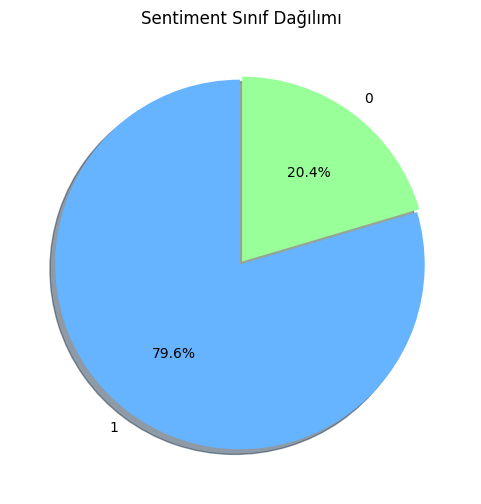

In [26]:
df['sentiment_label'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    figsize=(6, 6),
    explode=[0.01]*df['sentiment_label'].nunique(),
    colors=['#66b3ff', '#99ff99', '#ff9999']
)
plt.title("Sentiment Sınıf Dağılımı")
plt.ylabel("") 
plt.show()

## <span style="color:#FA8072"> 🔸 4.4 Veri Setinin Eğitim ve Test Olarak Ayrılması </span> <a class="anchor" id="load_data"></a>

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
                                                     X, y, 
                                                     test_size=0.2,
                                                     random_state=42,
                                                     stratify=y
)

In [28]:
X_train.head()

4774    memory card work advertised issue using gopro ...
586     needed new micro sd card flash boot project re...
4773    great price great manufacture item met need ne...
1589    love micro sd used main memory phone mostly ga...
4220    never problem sd card prior always good track ...
Name: reviewText, dtype: object

In [29]:
y_train.head()

4774    1
586     1
4773    1
1589    1
4220    1
Name: sentiment_label, dtype: int64

In [30]:
X_test.head()

2909            know android tablet three envy geek asian
1242    got phone first wouldnt work new version andro...
1839    large storage perfect tablet using asus maxing...
2422    month already dead gopro doesnt see memory car...
106     use phone work totally worth money great place...
Name: reviewText, dtype: object

In [31]:
y_test.head()

2909    0
1242    0
1839    1
2422    0
106     1
Name: sentiment_label, dtype: int64

## <span style="color:#FA8072"> 🔸 4.5 Metin Verisinin Vektörleştirilmesi </span> <a class="anchor" id="load_data"></a>

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">  
"reviewText" sütunundaki ham metinler doğrudan matematiksel işlemlere uygun bir yapıya sahip olmadıkları için, öncelikle bu metinlerden ölçülebilir nitelikte özellikler (features) türetilmesi gerekmektedir.
<br><br>
Bu amaçla, her bir yorumu temsil eden kelimeler sayısal temsillere (vektörlere) dönüştürülerek, metin verisi üzerinden makine öğrenmesi algoritmalarının çalışabileceği bir özellik matrisi (X) elde edilmiştir.
</div>

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">
    <p><strong>Yaygın olarak kullanılan bazı kelime vektörleştirme yöntemleri şunlardır:</strong></p>
    <ul>
        <li>CountVectorizer (kelime sıklığına dayalı basit temsil)</li>
        <li>TF-IDF (Term Frequency–Inverse Document Frequency)</li>
        <li>Word Embedding teknikleri: Word2Vec, GloVe, BERT vb.</li>
    </ul>
</div>   

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">
✅ Bu çalışmada, metin verisinden özellik çıkarımı için hem CountVectorizer (kelime düzeyinde) hem de TF-IDF (kelime düzeyinde ve n-gram düzeyinde) vektörleştirme yöntemleri kullanılmıştır.
<br><br>
Elde edilen bu sayısal temsiller üzerinden, Random Forest sınıflandırma modeli kurulmuş ve her yöntem için 5 katlı çapraz doğrulama (cross-validation) uygulanarak ortalama başarı skorları elde edilmiştir.
<br><br>
Amaç, en yüksek performansı sağlayan vektörleştirme yöntemini belirleyerek, sonraki modelleme adımlarında bu temsili kullanmaktır.
</div>

## <span style="color:#FA8072">    ➡️ 4.5.1 Count Vectors ile Kelime Tabanlı Özellik Çıkarımı </span> <a class="anchor" id="load_data"></a>

In [32]:
# CountVectorizer ile metni sayısal forma çevir
vectorizer = CountVectorizer()  # Ön tanımlı değer, kelime frekansları sayımıdır.
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

## <span style="color:#FA8072">  ➡️ 4.5.2 TF-IDF ile Kelime Tabanlı Özellik Çıkarımı </span> <a class="anchor" id="load_data"></a>

In [33]:
# TF-IDF ile vektörleştirme (kelime frekansı)
tf_idf_word_vectorizer = TfidfVectorizer()   #Ön tanımlı değer, kelime frekansları sayımıdır.
X_train_tfidf_word = tf_idf_word_vectorizer.fit_transform(X_train)
X_test_tfidf_word = tf_idf_word_vectorizer.transform(X_test)

## <span style="color:#FA8072">  ➡️ 4.5.3 TF-IDF ile N-Gram Tabanlı Özellik Çıkarımı </span> <a class="anchor" id="load_data"></a>

In [34]:
# TF-IDF n-gram vektörleştirme (2-gram ve 3-gram)
tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2, 3))
X_train_tfidf_ngram = tf_idf_ngram_vectorizer.fit_transform(X_train)
X_test_tfidf_ngram = tf_idf_ngram_vectorizer.transform(X_test)

## <span style="color:#FA8072">  🔸 4.6 Random Forest ile Vektörleştirme Yöntemlerinin Karşılaştırılması </span> <a class="anchor" id="load_data"></a> 

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">
 Elde edilen bu sayısal temsiller üzerinden, Random Forest sınıflandırma modeli kurulmuş ve her yöntem için 5 katlı çapraz doğrulama (cross-validation) uygulanarak ortalama başarı skorları elde edilmiştir.
<br><br>
Amaç, en yüksek performansı sağlayan vektörleştirme yöntemini belirleyerek, sonraki modelleme adımlarında bu temsili kullanmaktır.
</div>

In [35]:
# Count Vectors
rf_model = RandomForestClassifier().fit(X_train_count, y_train)
cross_val_score(rf_model, X_train_count, y_train, scoring="f1", cv=5, n_jobs=-1).mean()

0.9035494891685705

In [36]:
# TF-IDF Word-Level
rf_model = RandomForestClassifier().fit(X_train_tfidf_word, y_train)
cross_val_score(rf_model, X_train_tfidf_word, y_train, scoring="f1", cv=5, n_jobs=-1).mean()

0.8967746488716163

In [37]:
# TF-IDF N-GRAM
rf_model = RandomForestClassifier().fit(X_train_tfidf_ngram, y_train)
cross_val_score(rf_model, X_train_tfidf_ngram, y_train, scoring="f1", cv=5, n_jobs=-1).mean()

0.8699539140299404

<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">
Yapılan karşılaştırma sonucunda, en yüksek ortalama F1 skorunu sağlayan vektörleştirme yöntemi CountVectorizer olmuştur. Bu nedenle, modelleme sürecinin ilerleyen aşamalarında metin verisi, CountVectorizer temsili ile vektörleştirilerek kullanılacaktır.
</div>

## <span style="color:#FA8072"> 🔸 4.7 Count Vectors ile Random Forest Modeli </span> <a class="anchor" id="load_data"></a> 

In [38]:
# Random Forest modeli kur ve eğit
model_count = RandomForestClassifier(random_state=42)
model_count.fit(X_train_count, y_train)

RandomForestClassifier(random_state=42)

In [39]:
# Tahmin yap
y_pred_count = model_count.predict(X_test_count)

In [40]:
# Performans metrikleri
print("📊 CountVectorizer + Random Forest Performansı")
print("F1 Score:", f1_score(y_test, y_pred_count, pos_label= 1))
print("\nClassification Report:\n", classification_report(y_test, y_pred_count))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_count))

📊 CountVectorizer + Random Forest Performansı
F1 Score: 0.9049611476389718

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.33      0.46       201
           1       0.85      0.97      0.90       782

    accuracy                           0.84       983
   macro avg       0.79      0.65      0.68       983
weighted avg       0.82      0.84      0.81       983

Confusion Matrix:
 [[ 67 134]
 [ 25 757]]


## <span style="color:#FA8072"> ➡️ 4.7.1 Hiperparametre optimizasyonu </span> <a class="anchor" id="load_data"></a> 

In [41]:
rf_model = RandomForestClassifier(random_state=42)

In [42]:
rf_params = {"max_depth": [8, None],
             "max_features": [7, "sqrt"],
             "min_samples_split": [2, 5, 8],
             "n_estimators": [100, 200]}

In [43]:
rf_best_grid = GridSearchCV(
    rf_model,
    rf_params,
    cv=5,
    n_jobs=-1,
    scoring="f1",
    verbose=1
).fit(X_train_count, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [44]:
rf_best_grid.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 100}

In [45]:
best_model = rf_best_grid.best_estimator_
y_pred_best = best_model.predict(X_test_count)

In [46]:
f1 = f1_score(y_test, y_pred_best, pos_label= 1)  
print("F1 Score:", f1)

F1 Score: 0.9049611476389718


In [47]:
print("Classification Report:\n")
print(classification_report(y_test, y_pred_best))

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.33      0.46       201
           1       0.85      0.97      0.90       782

    accuracy                           0.84       983
   macro avg       0.79      0.65      0.68       983
weighted avg       0.82      0.84      0.81       983



<div style="background-color: #FFDAB9; padding: 15px; border-radius: 10px; font-family: Arial, sans-serif;">
Model, dengesiz sınıf dağılımına rağmen pozitif yorumları %90 F1 skoru ile başarılı bir şekilde tahmin etmektedir. Ancak negatif yorumlar için recall değeri %33’te kalmış ve bu durum negatif sınıfın yeterince iyi tanınamadığını göstermektedir. Bu sebeple, model pozitif odaklı sınıflandırmalarda güçlü performans gösterirken, negatif sınıfların daha iyi öğrenilmesi için veri dengeleme veya ağırlıklı eğitim stratejileri değerlendirilebilir.
</div>